In [1]:
import yaml
import os
import textwrap
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data wrangling
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr

In [3]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

In [4]:
# Models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [5]:
# Process control and optimization
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [6]:
# Models Pipelines
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [7]:
# Save model
import joblib

In [8]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [9]:
# Load the configuration file
with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Access the settings
project_folder = config['projectFolder']
df_path = os.path.join(project_folder, config['transformedDataFile'])
df = pd.read_csv(df_path)

In [10]:
# Define features (X) and target variable (y)
X = df.drop('% Silica Concentrate', axis=1)  # Features (all columns except 'Job Offer')
y = df['% Silica Concentrate']  # Target variable

In [11]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")
print("\n")

Training set size: (2747, 20)
Validation set size: (589, 20)
Test set size: (589, 20)




In [12]:
# Load saved model
model_path = '../model/final_model.pkl'  # Update with your actual path
final_model = joblib.load(model_path)

In [13]:
# Predict on the test set 
y_test_pred = final_model.predict(X_test)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae  = mean_absolute_error(y_test, y_test_pred)
r2   = r2_score(y_test, y_test_pred)

[LightGBM] [Warning] lambda_l1 is set=0.9364334886334374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9364334886334374
[LightGBM] [Warning] lambda_l2 is set=2.406570084459572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.406570084459572


Top 10 most important features:
                         Feature  Importance
19            % Iron Concentrate        7721
0                    % Iron Feed        4877
6   Flotation Column 01 Air Flow        3507
5               Ore Pulp Density        3441
4                    Ore Pulp pH        3302
2                     Amina Flow        3116
14     Flotation Column 03 Level        3062
7   Flotation Column 02 Air Flow        2926
18     Flotation Column 07 Level        2920
16     Flotation Column 05 Level        2894


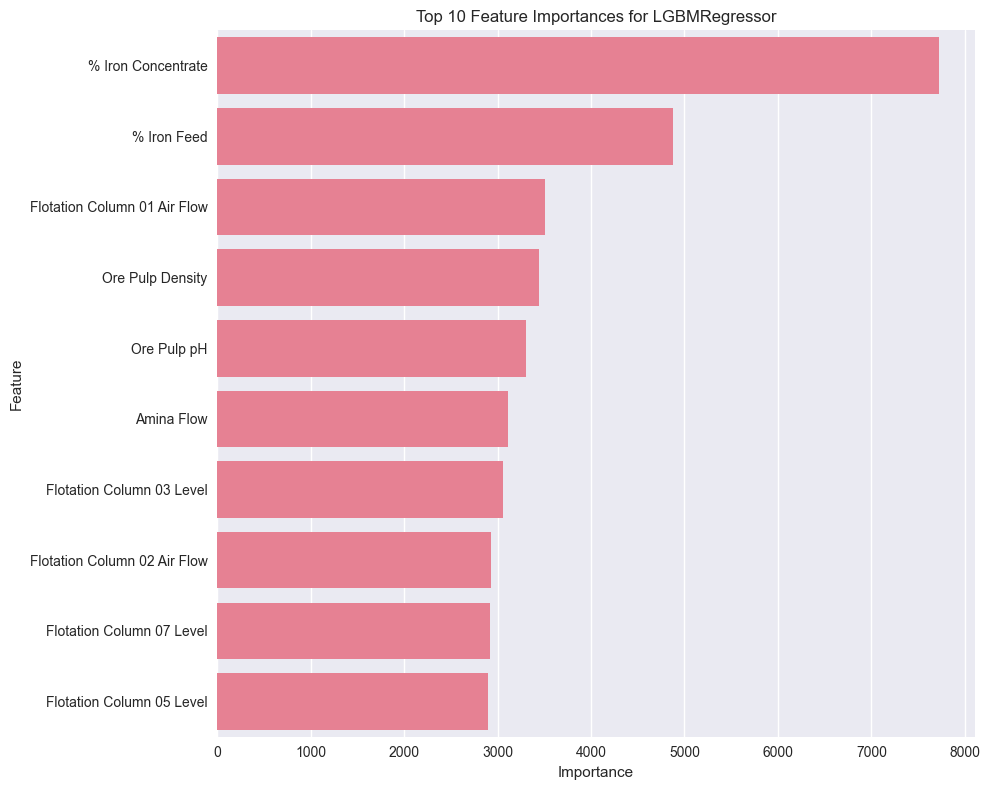

In [14]:
# Get feature importance
feature_importances = final_model.feature_importances_
feature_names = X.columns

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 most important features:")
print(importance_df.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title(f'Top 10 Feature Importances for {final_model.__class__.__name__}')
plt.tight_layout()
plt.show()

In [15]:
top_features = importance_df.head(5)['Feature'].tolist()
print(f"Top 5 most influential features for % Silica Concentrate:")

for i, feature in enumerate(top_features):
    print(f"{i+1}. {feature}")

# Analyze optimal ranges for important features
print("\nOptimal ranges for important features:")

for feature in top_features:
    # Create a DataFrame with feature values and target
    feature_analysis = pd.DataFrame({
        'feature': X[feature],
        'target': y
    })

    # Check for constant values
    if feature_analysis['feature'].nunique() <= 1:
        print(f"Skipping feature '{feature}' because it has constant values.")
        continue

    # Check for NaN or infinite values
    if feature_analysis['feature'].isna().sum() > 0 or feature_analysis['feature'].replace([np.inf, -np.inf], np.nan).isna().sum() > 0:
        print(f"Skipping feature '{feature}' because it contains NaN or infinite values.")
        continue

    # Group by feature percentiles and calculate average target
    try:
        feature_analysis['percentile'] = pd.qcut(feature_analysis['feature'], q=10, labels=False)
        grouped = feature_analysis.groupby('percentile')['target'].agg(['mean', 'std', 'count'])
        grouped['feature_min'] = [feature_analysis[feature_analysis['percentile']==p]['feature'].min() for p in range(10)]
        grouped['feature_max'] = [feature_analysis[feature_analysis['percentile']==p]['feature'].max() for p in range(10)]

        # Print optimal ranges
        print(f"\nFeature: {feature}")
        print(grouped)
    except ValueError as e:
        print(f"Error processing feature '{feature}': {e}")

Top 5 most influential features for % Silica Concentrate:
1. % Iron Concentrate
2. % Iron Feed
3. Flotation Column 01 Air Flow
4. Ore Pulp Density
5. Ore Pulp pH

Optimal ranges for important features:

Feature: % Iron Concentrate
                mean       std  count  feature_min  feature_max
percentile                                                     
0           4.275497  0.784950    395        62.05        63.39
1           3.589575  0.937611    397        63.40        64.12
2           2.852200  0.927853    387        64.13        64.59
3           2.327214  0.753174    400        64.60        64.93
4           2.116385  0.650658    398        64.94        65.21
5           1.920674  0.533732    432        65.22        65.44
6           1.801734  0.472585    358        65.45        65.72
7           1.658110  0.449454    381        65.73        66.02
8           1.466375  0.384726    387        66.03        66.36
9           1.267949  0.291767    390        66.37        68.01
E

In [16]:
# Find optimal range (with lowest target value for silica concentrate)
optimal_group = grouped.sort_values('mean').iloc[0]

print(f"\n{feature}:")
print(f"  Optimal range: {optimal_group['feature_min']:.2f} to {optimal_group['feature_max']:.2f}")
print(f"  Average % Silica Concentrate in this range: {optimal_group['mean']:.2f}%")
print(f"  Standard deviation: {optimal_group['std']:.2f}")
print(f"  Number of samples: {optimal_group['count']}")


Ore Pulp pH:
  Optimal range: 10.24 to 10.58
  Average % Silica Concentrate in this range: 2.01%
  Standard deviation: 1.01
  Number of samples: 393.0


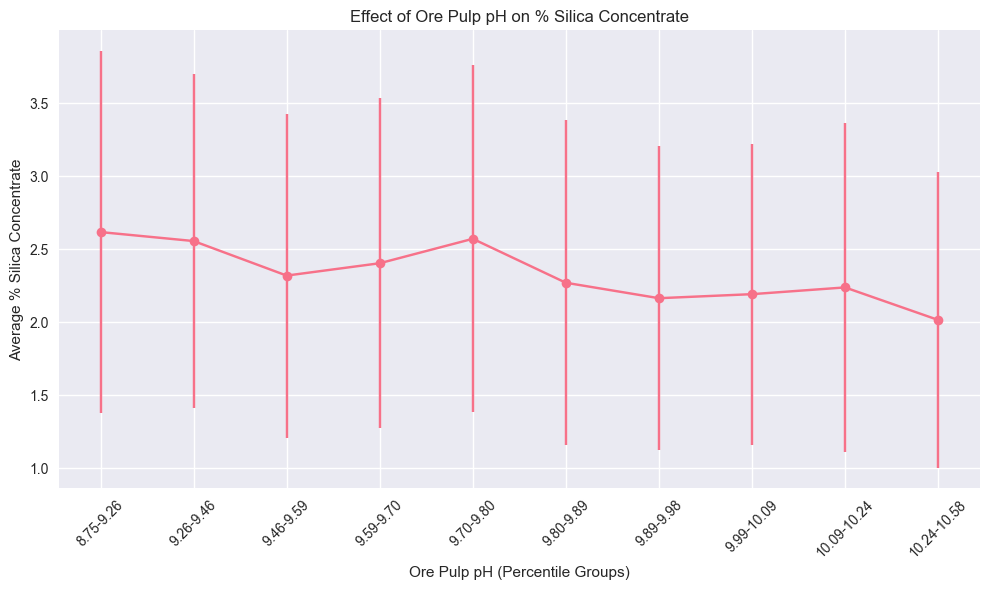

In [17]:
# Visualize the relationship
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(grouped)), grouped['mean'], yerr=grouped['std'], fmt='o-')
plt.xlabel(f'{feature} (Percentile Groups)')
plt.ylabel('Average % Silica Concentrate')
plt.title(f'Effect of {feature} on % Silica Concentrate')
plt.xticks(range(len(grouped)), [f"{g['feature_min']:.2f}-{g['feature_max']:.2f}" for _, g in grouped.iterrows()], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()


Interaction effects between top features:


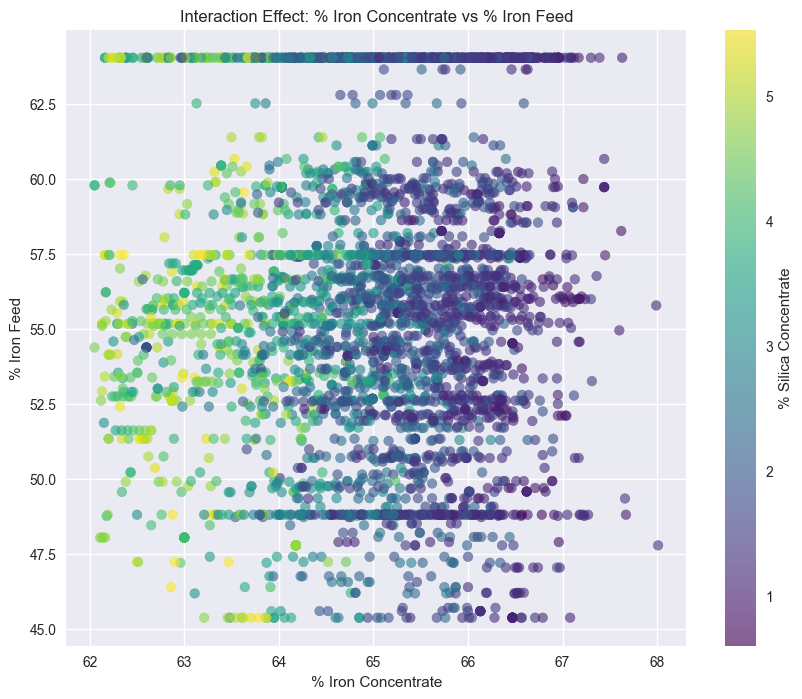

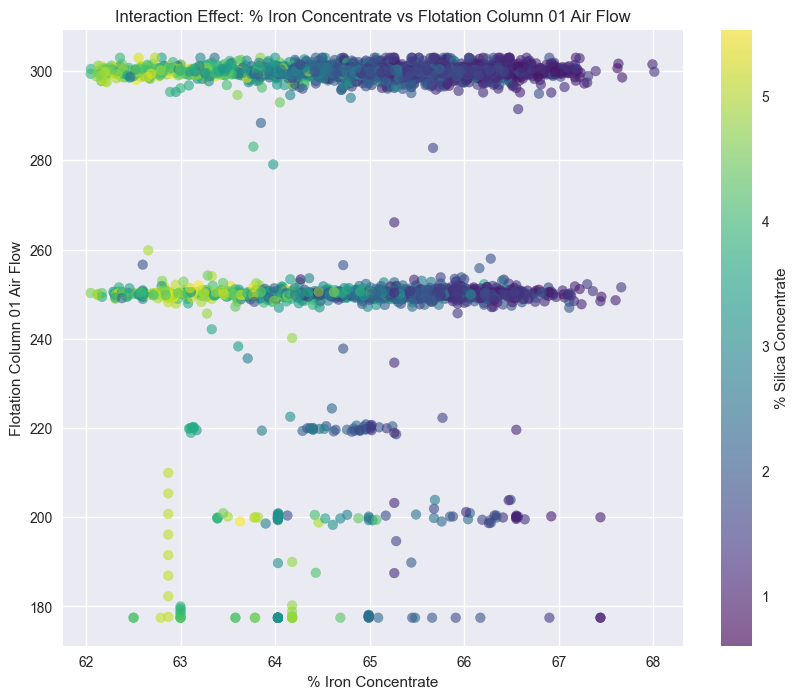

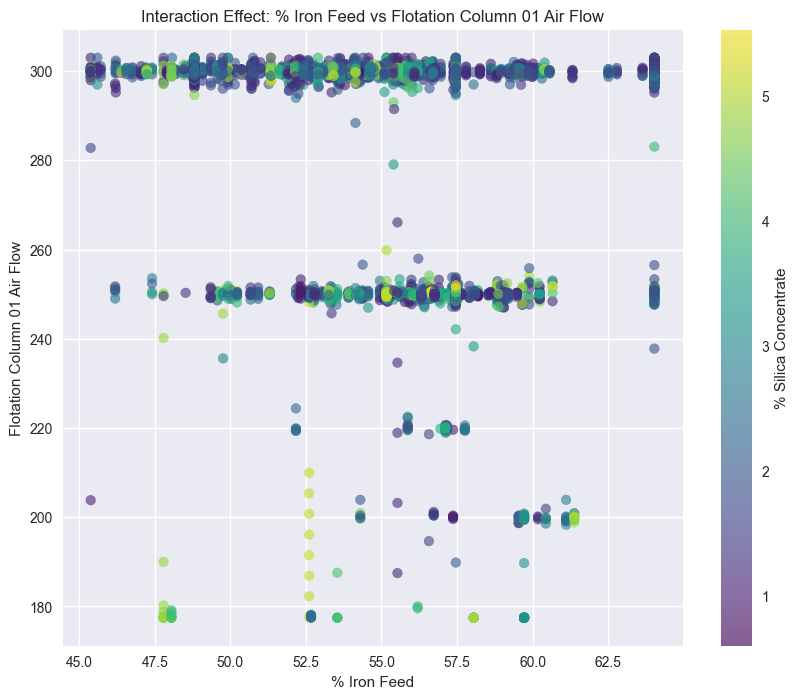

In [18]:
# Calculate interaction effects between top features
print("\nInteraction effects between top features:")
for i, feat1 in enumerate(top_features[:2]):  # Loop through the first two features
    for feat2 in top_features[i+1:3]:  # Analyze interactions between the top 3 features
        # Create a DataFrame to store the interaction data
        interaction_df = pd.DataFrame({
            'feat1': X[feat1],
            'feat2': X[feat2],
            'target': y
        })

        # Plot the interaction effect
        plt.figure(figsize=(10, 8))
        plt.scatter(interaction_df['feat1'], interaction_df['feat2'], c=interaction_df['target'], cmap='viridis', alpha=0.6)
        plt.colorbar(label='% Silica Concentrate')
        plt.xlabel(feat1)
        plt.ylabel(feat2)
        plt.title(f'Interaction Effect: {feat1} vs {feat2}')
        plt.show()

In [19]:
# Create bins for both features
interaction_df['feat1_bin'] = pd.qcut(interaction_df['feat1'], q=5, labels=False)
interaction_df['feat2_bin'] = pd.qcut(interaction_df['feat2'], q=5, labels=False)

In [20]:
# Calculate average target for each combination of binned features
pivot = interaction_df.pivot_table(
    values='target',
    index='feat1_bin',
    columns='feat2_bin',
    aggfunc='mean'
)

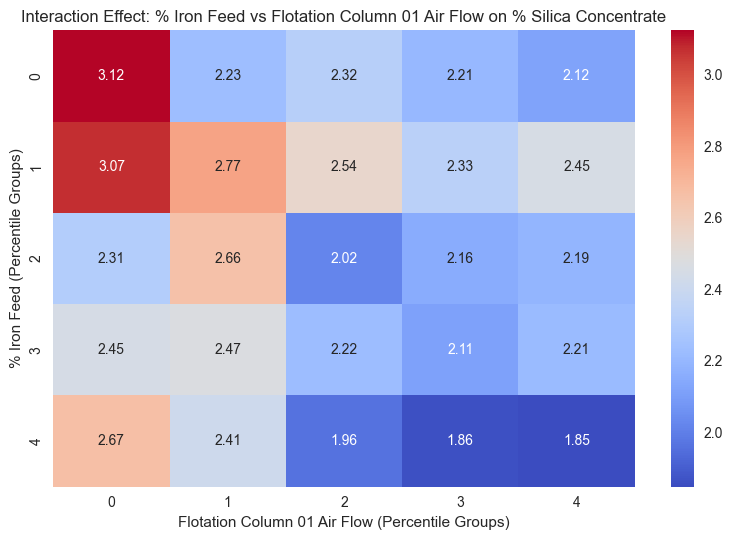

In [21]:
# Plot heatmap
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm')
plt.title(f'Interaction Effect: {feat1} vs {feat2} on % Silica Concentrate')
plt.xlabel(f'{feat2} (Percentile Groups)')
plt.ylabel(f'{feat1} (Percentile Groups)')
plt.tight_layout()
plt.savefig(f'interaction_{feat1}_{feat2}.png')
plt.show()
plt.close()

In [22]:
print(f"\nInteraction between {feat1} and {feat2}:")
min_val = pivot.min().min()
min_pos = np.where(pivot.values == min_val)
print(f"  Optimal combination (lowest % Silica Concentrate: {min_val:.2f}%):")
print(f"  {feat1}: Percentile group {min_pos[0][0]}")
print(f"  {feat2}: Percentile group {min_pos[1][0]}")


Interaction between % Iron Feed and Flotation Column 01 Air Flow:
  Optimal combination (lowest % Silica Concentrate: 1.85%):
  % Iron Feed: Percentile group 4
  Flotation Column 01 Air Flow: Percentile group 4


In [23]:
# Create a function to suggest control recommendations based on model findings
def generate_control_recommendations():
    recommendations = [
        "Based on the model analysis, here are the key process control recommendations:",
    ]

    # Add recommendations based on feature importance
    recommendations.append("\n1. Focus on controlling the following parameters (in order of importance):")
    
    for i, feature in enumerate(top_features[:5]):
        recommendations.append(f"   - {feature}")

    # Add recommendations based on optimal ranges
    recommendations.append("\n2. Maintain process variables within these optimal ranges:")
    for feature in top_features[:3]:
        # Get optimal range
        feature_analysis = pd.DataFrame({
            'feature': X[feature],
            'target': y
        })
        # KEY FIX: Add duplicates='drop' parameter
        feature_analysis['percentile'] = pd.qcut(
            feature_analysis['feature'], 
            q=10, 
            labels=False, 
            duplicates='drop'
        )
        grouped = feature_analysis.groupby('percentile')['target'].mean()
        best_percentile = grouped.idxmin()

        feature_subset = feature_analysis[feature_analysis['percentile'] == best_percentile]
        optimal_min = feature_subset['feature'].min()
        optimal_max = feature_subset['feature'].max()

        recommendations.append(f"   - {feature}: {optimal_min:.2f} to {optimal_max:.2f}")

    # Add recommendations based on interaction effects
    recommendations.append("\n3. Consider the following interaction effects:")
    for i, feat1 in enumerate(top_features[:2]):
        for feat2 in top_features[i+1:3]:
            recommendations.append(f"   - Jointly optimize {feat1} and {feat2} for best results")

    # Add general recommendations
    recommendations.extend([
        "\n4. Implement real-time monitoring for the key variables identified",
        "5. Establish a feedback control system to maintain optimal parameter ranges",
        "6. Regularly collect and analyze data to update the model and refine recommendations",
        "7. Consider implementing a predictive maintenance program based on the identified parameters"
    ])

    return "\n".join(recommendations)

In [24]:
# Generate and print recommendations
process_recommendations = generate_control_recommendations()
print(process_recommendations)

Based on the model analysis, here are the key process control recommendations:

1. Focus on controlling the following parameters (in order of importance):
   - % Iron Concentrate
   - % Iron Feed
   - Flotation Column 01 Air Flow
   - Ore Pulp Density
   - Ore Pulp pH

2. Maintain process variables within these optimal ranges:
   - % Iron Concentrate: 66.37 to 68.01
   - % Iron Feed: 64.03 to 64.03
   - Flotation Column 01 Air Flow: 299.98 to 300.33

3. Consider the following interaction effects:
   - Jointly optimize % Iron Concentrate and % Iron Feed for best results
   - Jointly optimize % Iron Concentrate and Flotation Column 01 Air Flow for best results
   - Jointly optimize % Iron Feed and Flotation Column 01 Air Flow for best results

4. Implement real-time monitoring for the key variables identified
5. Establish a feedback control system to maintain optimal parameter ranges
6. Regularly collect and analyze data to update the model and refine recommendations
7. Consider implemen

In [25]:
# ------------------------------------------------------------------
# 1️⃣  CONFIGURATION
# ------------------------------------------------------------------
TOP_K = 5           # how many single features to highlight
BINS  = 10          # percentiles for univariate range analysis
INT_PAIRS = 2       # how many top features to inspect for interactions

# ------------------------------------------------------------------
# 2️⃣  HELPERS
# ------------------------------------------------------------------
def _optimal_range(feature_series: pd.Series, target: pd.Series, q=BINS):
    """Return (best_min, best_max, best_mean, best_std, best_count)."""
    df = pd.DataFrame({"feat": feature_series, "y": target})
    df["bin"] = pd.qcut(df["feat"], q=q, labels=False, duplicates="drop")
    stats = df.groupby("bin")["y"].agg(["mean", "std", "count"])
    idx   = stats["mean"].idxmin()                              # best (lowest) mean
    subset = df[df["bin"] == idx]["feat"]
    return subset.min(), subset.max(), stats.loc[idx, "mean"], stats.loc[idx, "std"], stats.loc[idx, "count"]

def _interaction_summary(f1, f2, X, y, q=5):
    """Return the (bin_f1, bin_f2, min_mean) combination with lowest mean y."""
    tmp = pd.DataFrame({f1: X[f1], f2: X[f2], "y": y})
    tmp["bin1"] = pd.qcut(tmp[f1], q=q, labels=False, duplicates="drop")
    tmp["bin2"] = pd.qcut(tmp[f2], q=q, labels=False, duplicates="drop")
    pivot = tmp.pivot_table(values="y", index="bin1", columns="bin2", aggfunc="mean")
    idx = np.unravel_index(pivot.values.argmin(), pivot.shape)
    return int(idx[0]), int(idx[1]), float(pivot.values.min())

def _md_bold(txt):  # tiny helper for bold formatting
    return f"**{txt}**"

In [26]:
# ------------------------------------------------------------------
# 3️⃣  MAIN AUTO-SUMMARY FUNCTION
# ------------------------------------------------------------------
def generate_analysis_summary(X, y, importance_df,
                              top_k=TOP_K, bins=BINS, int_pairs=INT_PAIRS):
    # --- Top-k features
    top_features = importance_df.sort_values("Importance", ascending=False)\
                                .head(top_k)["Feature"].tolist()

    # --- Optimal ranges per feature
    range_info = {}
    for feat in top_features:
        best_min, best_max, best_mean, best_std, best_cnt = _optimal_range(X[feat], y, q=bins)
        range_info[feat] = (best_min, best_max, best_mean, best_std, best_cnt)

    # --- Interaction (first vs second most important)
    if len(top_features) >= 2:
        f1, f2 = top_features[0], top_features[1]
        bin1, bin2, min_mean = _interaction_summary(f1, f2, X, y, q=5)
        interaction_text = (
            f"The combination of {f1} percentile **{bin1}** and {f2} percentile "
            f"**{bin2}** yields the *lowest* average silica concentration "
            f"({min_mean:.2f} %)."
        )
    else:
        interaction_text = "Not enough features to compute interaction effects."

    # --- Build Markdown summary
    lines = []

    lines.append("# Mining-Process Flotation-Plant Analysis Summary\n")
    lines.append("## Key Findings:")

    # 1. Feature importance
    lines.append("1. " + _md_bold("Top Influential Features") + ":")
    for f in top_features:
        lines.append(f"   - {f}")

    # 2. Optimal ranges
    lines.append("\n2. " + _md_bold("Optimal Ranges") + ":")
    for f, (mn, mx, mean, *_ ) in range_info.items():
        lines.append(f"   - {f}: {mn:.2f} – {mx:.2f} (avg silica ≈ {mean:.2f} %)")

    # 3. Interaction
    lines.append("\n3. " + _md_bold("Interaction Effects") + ":")
    lines.append(f"   - {interaction_text}")

    # 4. Recommendations
    lines.append("\n4. " + _md_bold("Recommendations") + ":")
    lines.extend([
        "   - Maintain the key variables above within their optimal ranges.",
        f"   - Jointly tune {top_features[0]} and {top_features[1]} as indicated.",
        "   - Implement real-time monitoring and feedback control on these parameters.",
        "   - Periodically retrain the model to capture process drifts.",
    ])

    # --- Join everything
    summary_text = "\n".join(lines)
    return textwrap.dedent(summary_text)

In [27]:
# ------------------------------------------------------------------
# 4️⃣  USAGE
# ------------------------------------------------------------------
auto_summary = generate_analysis_summary(X, y, importance_df)
print(auto_summary)

# Mining-Process Flotation-Plant Analysis Summary

## Key Findings:
1. **Top Influential Features**:
   - % Iron Concentrate
   - % Iron Feed
   - Flotation Column 01 Air Flow
   - Ore Pulp Density
   - Ore Pulp pH

2. **Optimal Ranges**:
   - % Iron Concentrate: 66.37 – 68.01 (avg silica ≈ 1.27 %)
   - % Iron Feed: 64.03 – 64.03 (avg silica ≈ 2.06 %)
   - Flotation Column 01 Air Flow: 299.98 – 300.33 (avg silica ≈ 2.02 %)
   - Ore Pulp Density: 1.56 – 1.63 (avg silica ≈ 2.16 %)
   - Ore Pulp pH: 10.24 – 10.58 (avg silica ≈ 2.01 %)

3. **Interaction Effects**:
   - The combination of % Iron Concentrate percentile **4** and % Iron Feed percentile **4** yields the *lowest* average silica concentration (1.31 %).

4. **Recommendations**:
   - Maintain the key variables above within their optimal ranges.
   - Jointly tune % Iron Concentrate and % Iron Feed as indicated.
   - Implement real-time monitoring and feedback control on these parameters.
   - Periodically retrain the model to captu

In [28]:
#  Conclusion
print("\n17. CONCLUSION")
print("-------------")
print(f"Analysis of the mining process flotation plant has been successfully completed.")
print(f"A {final_model.__class__.__name__} model was developed that can predict the silica concentrate percentage with an RMSE of {rmse:.4f}.")
print(f"The model has an R² of {r2:.4f}, indicating it explains {r2:.2%} of the variance in the target variable.")
print("Key process variables and optimal ranges have been identified to help optimize the flotation process.")
print("The model and prediction function have been saved for deployment.")
print("\nThank you for using this analysis script!")


17. CONCLUSION
-------------
Analysis of the mining process flotation plant has been successfully completed.
A LGBMRegressor model was developed that can predict the silica concentrate percentage with an RMSE of 0.5530.
The model has an R² of 0.7438, indicating it explains 74.38% of the variance in the target variable.
Key process variables and optimal ranges have been identified to help optimize the flotation process.
The model and prediction function have been saved for deployment.

Thank you for using this analysis script!
